In [21]:
# Connection
import mysql.connector
import sys

# Utility
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# Preprocessing
# import string
from nltk import *
import nltk
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger') #pour pos_tag

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.corpus import wordnet as wn

# Modelling
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D , Activation, InputLayer, LSTM
from tensorflow.keras.layers import Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import (classification_report, confusion_matrix, 
                            f1_score,accuracy_score, precision_score, 
                             recall_score, roc_auc_score) 

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [22]:
def connect():
    try:
        cnx = mysql.connector.connect(host="localhost",user="root",password="root",auth_plugin='mysql_native_password',database="sentiment_analysis")
    except mysql.connector.Error as err:
        cnx = False
        print(err)
        sys.exit(1)
    finally:
        return cnx

In [23]:
conn = connect()
conn
cursor = conn.cursor()

In [24]:
def create_dataframe():
    cursor.execute("""  SELECT *
                    FROM clothing_reviews; """)
    rows = cursor.fetchall()
    df = pd.DataFrame(rows,columns=['Index','Clothing ID', 'Age', 'Title', 'Review Text', 'Rating',
       'Recommended IND', 'Positive Feedback Count', 'Division Name',
       'Department Name', 'Class Name'])
    df = df.set_index('Index')
    df = df.replace('',np.nan,regex = True)
    return df

In [25]:
df_ori = create_dataframe()

# Cleaning

In [26]:
#Suppression de 845 données car il nous faut absolument TOUTES les Review Text
df_ori.dropna(subset=['Review Text'], inplace=True)
# df_ori.isna().sum()

In [27]:
df = df_ori[["Review Text","Recommended IND"]]

In [28]:
stop_words = stopwords.words('english')

In [29]:
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wn.ADJ
    elif tag.startswith('V'):
        return wn.VERB
    elif tag.startswith('N'):
        return wn.NOUN
    elif tag.startswith('R'):
        return wn.ADV
    else:
        return wn.NOUN

In [30]:
def cleaning(data):
    
    #1. Tokenize
    text_tokens = word_tokenize(data.replace("'", "").lower()) 
        
    #2. Remove Puncs
    tokens_without_punc = [w for w in text_tokens if w.isalpha()]  
    
    #3. Removing Stopwords
    tokens_without_sw = [t for t in tokens_without_punc if t not in stop_words]
    
    #4. Lemmatize
    POS_tagging = pos_tag(tokens_without_sw)
    wordnet_pos_tag=[]
    wordnet_pos_tag = [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in POS_tagging]
    wnl = WordNetLemmatizer()
    lemma = [wnl.lemmatize(word, tag) for word, tag in wordnet_pos_tag]
    
    return " ".join(lemma)

In [31]:
df['Document'] = df['Review Text'].apply(cleaning)
df

C:\Users\Admin\AppData\Local\Temp\ipykernel_158004\4105619847.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Document'] = df['Review Text'].apply(cleaning)


,Review Text,Recommended IND,Document
Index,,,
1,Absolutely wonderful - silky and sexy and comf...,1,absolutely wonderful silky sexy comfortable
2,Love this dress! it's sooo pretty. i happene...,1,love dress sooo pretty happen find store im gl...
3,I had such high hopes for this dress and reall...,0,high hope dress really wanted work initially o...
4,"I love, love, love this jumpsuit. it's fun, fl...",1,love love love jumpsuit fun flirty fabulous ev...
5,This shirt is very flattering to all due to th...,1,shirt flatter due adjustable front tie perfect...
...,...,...,...
23482,I was very happy to snag this dress at such a ...,1,happy snag dress great price easy slip flatter...
23483,"It reminds me of maternity clothes. soft, stre...",1,reminds maternity clothes soft stretchy shiny ...
23484,"This fit well, but the top was very see throug...",0,fit well top see never would work im glad able...


In [32]:
# df.to_csv('./datasets/df_cleaned.csv')

In [33]:
df = pd.read_csv("./datasets/df_cleaned.csv")

# Modèle DL

In [34]:
X = df["Document"].values
y = df["Recommended IND"].values

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 101)

# RandomUnderSampling

In [36]:
rus = RandomUnderSampler(random_state=42,sampling_strategy=0.6)
X_rus, y_rus = rus.fit_resample(X_train.reshape(-1, 1), y_train.reshape(-1, 1))

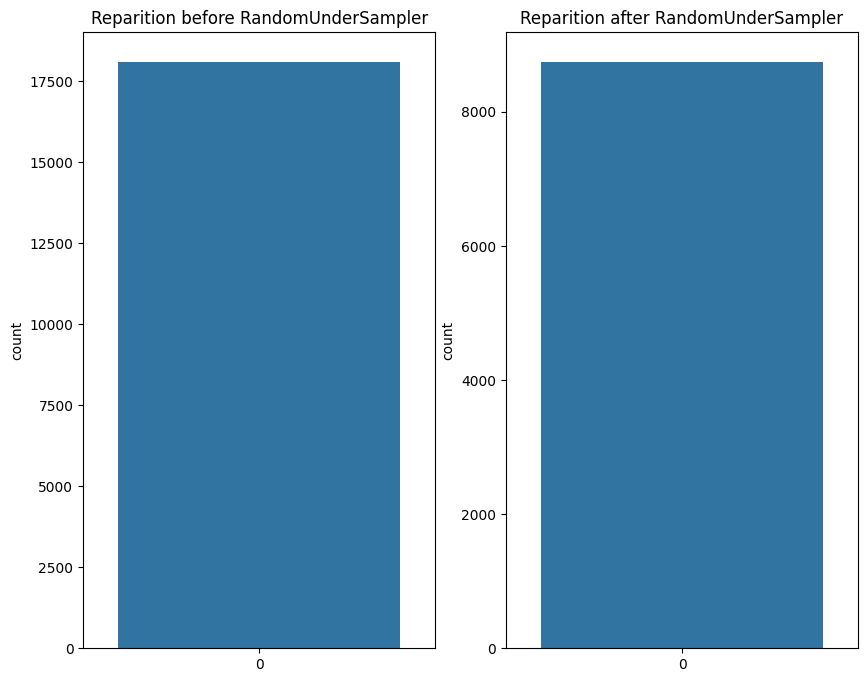

In [37]:
plt.figure(figsize = (10, 8))
plt.subplot(1, 2, 1)
sns.countplot(y_train)
plt.title('Reparition before RandomUnderSampler')
plt.subplot(1, 2, 2)
sns.countplot(y_rus)
plt.title('Reparition after RandomUnderSampler')
plt.show()

### MODELE LSTM

In [136]:
#Parametres

TOKENIZER_NUM_WORDS = None #None by default
SEQUENCE_LENGTH = 300 #None by default

# model
EPOCHS = 30
BATCH_SIZE = 1024

In [137]:
def LSTM_Model(train_x, train_y, neurons=10, optimizer='adam', vocab_size=vocab_size, input_shape=input_shape):
    lstm_model = Sequential()
    lstm_model.add(InputLayer(input_shape=(input_shape,)))
    lstm_model.add(Embedding(vocab_size,SEQUENCE_LENGTH,input_length=input_shape))
    lstm_model.add(LSTM(neurons, return_sequences=True)) #return sequences ?
    lstm_model.add(Flatten())
    lstm_model.add(Dense(1, activation="sigmoid"))
    #compile the model
    lstm_model.compile(loss="binary_crossentropy",optimizer=optimizer,metrics=["accuracy"])
    return lstm_model

In [138]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=5, restore_best_weights=True)

In [38]:
#Reshape en tableau pour passer dans le tokenizer
X_train_rus = X_rus.reshape(-1)
y_train_rus = y_rus.reshape(-1)

In [143]:
%%time

#Tokenize

tokenizer = Tokenizer(num_words=TOKENIZER_NUM_WORDS)
tokenizer.fit_on_texts(X_train_rus)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 7532
Wall time: 472 ms


In [144]:
%%time
X_train_padseq_rus = pad_sequences(tokenizer.texts_to_sequences(X_train_rus), maxlen=SEQUENCE_LENGTH)
X_test_padseq = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=SEQUENCE_LENGTH)

input_shape = X_train_padseq_rus.shape[1]

Wall time: 552 ms


In [145]:
lstm_model = LSTM_Model(train_x=X_train_padseq_rus,train_y=y_train_rus,vocab_size=vocab_size, input_shape=input_shape)

In [146]:
%%time
history = lstm_model.fit(X_train_padseq_rus, y_train_rus,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.3,
                    callbacks=[early_stopping])

Epoch 1/30
6/6 [==============================] - 19s 3s/step - loss: 0.6904 - accuracy: 0.5358 - val_loss: 0.7272 - val_accuracy: 0.0000e+00
Epoch 2/30
6/6 [==============================] - 23s 4s/step - loss: 0.6830 - accuracy: 0.5358 - val_loss: 0.7583 - val_accuracy: 0.0000e+00
Epoch 3/30
6/6 [==============================] - 24s 4s/step - loss: 0.6667 - accuracy: 0.5870 - val_loss: 0.7232 - val_accuracy: 0.3208
Epoch 4/30
6/6 [==============================] - 36s 6s/step - loss: 0.6321 - accuracy: 0.7580 - val_loss: 0.6668 - val_accuracy: 0.6552
Epoch 5/30
6/6 [==============================] - 32s 4s/step - loss: 0.5708 - accuracy: 0.8263 - val_loss: 0.5998 - val_accuracy: 0.7307
Epoch 6/30
6/6 [==============================] - 25s 4s/step - loss: 0.4861 - accuracy: 0.8452 - val_loss: 0.5473 - val_accuracy: 0.7451
Epoch 7/30
6/6 [==============================] - 29s 5s/step - loss: 0.4069 - accuracy: 0.8508 - val_loss: 0.4622 - val_accuracy: 0.7863
Epoch 8/30
6/6 [==========

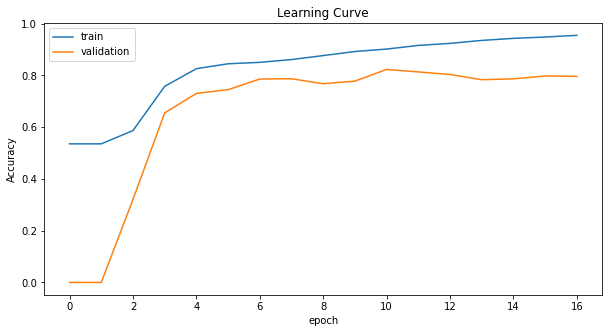

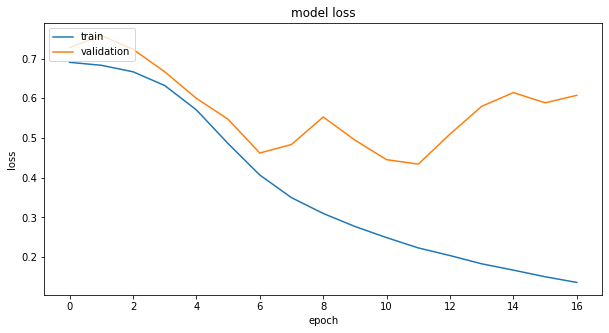

In [147]:
plt.figure(figsize=(10,5))

# summarize history for mae
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Learning Curve')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

##### Prediction

In [148]:
pred_train_lstm_rus = lstm_model.predict(X_train_padseq_rus)
pred_test_lstm = lstm_model.predict(X_test_padseq)

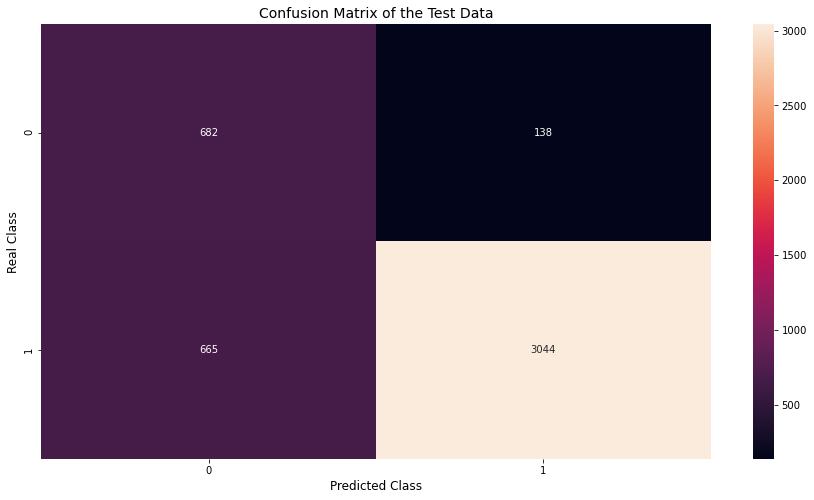

In [149]:
for i, x in enumerate(pred_test_lstm):
    if 0 <= x < 0.49:
        pred_test_lstm[i] = 0
    else:
        pred_test_lstm[i] = 1

for i, x in enumerate(pred_train_lstm_rus):
    if 0 <= x < 0.49:
        pred_train_lstm_rus[i] = 0
    else:
        pred_train_lstm_rus[i] = 1

conf_mat = confusion_matrix(y_true=y_test, y_pred=pred_test_lstm)
plt.figure(figsize=(15, 8))
sns.heatmap(conf_mat, annot=True, fmt='g')
plt.title('Confusion Matrix of the Test Data', fontsize=14)
plt.ylabel('Real Class', fontsize=12)
plt.xlabel('Predicted Class', fontsize=12)
plt.show()

In [150]:
print(classification_report(y_test, pred_test_lstm))

              precision    recall  f1-score   support

           0       0.51      0.83      0.63       820
           1       0.96      0.82      0.88      3709

    accuracy                           0.82      4529
   macro avg       0.73      0.83      0.76      4529
weighted avg       0.88      0.82      0.84      4529



In [152]:
lstm_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 300, 300)          2259600   
                                                                 
 lstm_5 (LSTM)               (None, 300, 10)           12440     
                                                                 
 flatten_5 (Flatten)         (None, 3000)              0         
                                                                 
 dense_5 (Dense)             (None, 1)                 3001      
                                                                 
Total params: 2,275,041
Trainable params: 2,275,041
Non-trainable params: 0
_________________________________________________________________


In [153]:
# # saving tokenizer
# with open('./mypickles/tokenizer_rus.pickle', 'wb') as handle:
#     pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [154]:
# # saving model lstm with rus
# lstm_model.save('./mypickles/lstm_model_rus.h5')

### MODELE BERT

In [20]:
X_test, y_test
X_rus
y_rus
X_train_rus
y_train_rus 

NameError: name 'X_rus' is not defined

In [51]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TFBertModel

In [73]:
from torch import tensor

In [19]:
# Set the model name
MODEL_NAME = 'bert-base-cased'

# Build a BERT based tokenizer
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

C:\Users\Admin\Documents\marianneSimplon\simplon\sentiment_analysis_virtual_DL\venv\lib\site-packages\huggingface_hub\file_download.py:127: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Admin\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [39]:
MAX_LEN = 300

In [40]:
def tokenize(data,max_len=MAX_LEN) :
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer.encode_plus(
            data[i],
            add_special_tokens=True,
            max_length=MAX_LEN,
            padding='max_length',
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

In [79]:
%%time
labels_train = tensor(y_train)
labels_test = tensor(y_test)

CPU times: total: 0 ns
Wall time: 998 µs


In [49]:
%%time
train_input_ids, train_attention_masks = tokenize(X_train_rus, MAX_LEN)
test_input_ids, test_attention_masks = tokenize(X_test, MAX_LEN)

In [52]:
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/536M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [57]:
import tensorflow_addons as tfa

In [59]:
tfa.metrics.F1Score

tensorflow_addons.metrics.f_scores.F1Score

In [90]:
def create_model(bert_model, max_len):
    
    ##params###
    opt = tf.keras.optimizers.Adam()
    loss = tf.keras.losses.BinaryCrossentropy()
#     f1_score = tfa.metrics.F1Score(num_classes=2)
    accuracy = tf.keras.metrics.CategoricalAccuracy()


    input_ids = tf.keras.Input(shape=(max_len,),dtype='int32')
    
    attention_masks = tf.keras.Input(shape=(max_len,),dtype='int32')
    
    embeddings = bert_model([input_ids,attention_masks])[1]
    
    output = tf.keras.layers.Dense(1, activation="softmax")(embeddings)
    
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks], outputs = output)
    
    model.compile(opt, loss=loss, metrics=accuracy)
    
    
    return model

In [91]:
model = create_model(bert_model, MAX_LEN)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_3[0][0]',                
                                thPoolingAndCrossAt               'input_4[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 300,                                         

In [87]:
print(X_train_rus.shape)
print(y_train_rus.shape)
print(train_input_ids.shape)
print(train_attention_masks.shape)
print(labels_train.shape)
print(y_train_rus.shape)
print(y_rus.shape)

(8749,)
(8749,)
(8749, 300)
(8749, 300)
torch.Size([18112])
(8749,)
(8749,)


In [93]:
history_bert = model.fit([train_input_ids,train_attention_masks], y_train_rus, validation_split=0.3, epochs=4, batch_size=32,verbose=2)

Epoch 1/4


KeyboardInterrupt: 

In [ ]:
result_bert = model.predict([test_input_ids,test_attention_masks])

In [ ]:
y_pred_bert =  np.zeros_like(result_bert)
y_pred_bert[np.arange(len(y_pred_bert)), result_bert.argmax(1)] = 1

In [ ]:
conf_matrix(y_test.argmax(1), y_pred_bert.argmax(1),'BERT Sentiment Analysis\nConfusion Matrix')

In [ ]:
print('\tClassification Report for BERT:\n\n',classification_report(y_test,y_pred_bert, target_names=['Non Recommandé', 'Recommandé']))

# END

In [ ]:
def tokenize(data,max_len=MAX_LEN) :
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer.encode_plus(
            data[i],
            add_special_tokens=True,
            max_length=MAX_LEN,
            padding='max_length',
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

In [ ]:
train_input_ids, train_attention_masks = tokenize(X_train, MAX_LEN)
val_input_ids, val_attention_masks = tokenize(X_valid, MAX_LEN)
test_input_ids, test_attention_masks = tokenize(X_test, MAX_LEN)

In [ ]:
def create_model(bert_model, max_len=MAX_LEN):
    
    ##params###
    opt = tf.keras.optimizers.Adam(learning_rate=1e-5, decay=1e-7)
    loss = tf.keras.losses.CategoricalCrossentropy()
    accuracy = tf.keras.metrics.CategoricalAccuracy()


    input_ids = tf.keras.Input(shape=(max_len,),dtype='int32')
    
    attention_masks = tf.keras.Input(shape=(max_len,),dtype='int32')
    
    embeddings = bert_model([input_ids,attention_masks])[1]
    
    output = tf.keras.layers.Dense(3, activation="softmax")(embeddings)
    
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks], outputs = output)
    
    model.compile(opt, loss=loss, metrics=accuracy)
    
    
    return model

In [ ]:
model = create_model(bert_model, MAX_LEN)
model.summary()

In [ ]:
history_bert = model.fit([train_input_ids,train_attention_masks], y_train, validation_data=([val_input_ids,val_attention_masks], y_valid), epochs=4, batch_size=32)

In [ ]:
encoder_train = tokenizer.batch_encode_plus(df[df["data_type"]=='train'].Text.values,
                                           add_special_tokens = True,
                                            return_attention_masks = True,
                                           pad_to_max_length = True,
                                           max_length = 256,
                                           return_tensors = 'pt')



encoder_test = tokenizer.batch_encode_plus(df[df["data_type"]=='test'].Text.values,
                                           add_special_tokens = True,
                                            return_attention_masks = True,
                                           pad_to_max_length = True,
                                           max_length = 256,
                                           return_tensors = 'pt')

input_ids_train = encoder_train['input_ids']
attention_masks_train = encoder_train["attention_mask"]
labels_train = torch.tensor(df[df['data_type']=='train'].Label.values)


input_ids_test = encoder_test['input_ids']
attention_masks_test = encoder_test["attention_mask"]
labels_test = torch.tensor(df[df['data_type']=='test'].Label.values)